# Quantum Characterisation, Verification and Validation


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/qcvv/qcvv_css.ipynb)
[![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supermarq/qcvv/qcvv_css.ipynb)


To demonstrate how to implement new benchmarking experiments within the Superstaq QCVV framework,
consider implementing a naive benchmarking routine where we try to estimate the fidelity of a single
qubit Z gate by repeatedly applying the gate to a qubit in the ground state (such that the Z-gate
should have no effect) and observing if any observations of the excited state occur. If the excited
state is observed this indicates an error has occurred. Assuming that each time the Z-gate is
applied the probability of a bit flip error is $e$ then after $d$ gates the probability of observing
the ground state is $$p(0) = \frac{1}{2}(1-e)^d + \frac{1}{2}$$


We can create an experiment to measure this as follows


In [1]:
from __future__ import annotations

In [2]:
try:
    import supermarq
except ImportError:
    print("Installing supermarq...")
    %pip install --quiet supermarq
    print("Installed supermarq.")
    print("You may need to restart the kernel to import newly installed packages.")

In [5]:
from supermarq.qcvv import QCVVExperiment, Sample, QCVVResults
from dataclasses import dataclass
from collections.abc import Sequence
from typing import Iterable
from tqdm.contrib.itertools import product

import cirq

from scipy.stats import linregress
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


@dataclass(repr=False)
class NaiveExperimentResult(QCVVResults):
    gate_fidelity: float = 1
    gate_error: float = 0

    def _analyze(self) -> None:
        """To analyse the results to fit a simple exponential decay. This can be done easily
        by fitting a linear model to the logarithm of the equation above.
        """

        model = linregress(x=self.data["depth"], y=np.log(2 * self.data["0"] - 1))

        self.gate_fidelity = np.exp(model.slope)

        self.gate_error = 1 - np.exp(model.slope)

    def plot_results(self) -> None:
        """Plot the data with the fit superimposed on top."""

        fig, axs = plt.subplots(
            1,
        )

        sns.scatterplot(self.data, x="depth", y="0", ax=axs)

        x = np.linspace(0, max(self.data.depth))
        y = 0.5 * self.gate_fidelity**x + 0.5
        axs.plot(x, y)
        axs.set_xlabel("Circuit depth")
        axs.set_ylabel("Probability of ground state")

    def _results_msg(self) -> str:
        return f"Estimated gate error: {self.gate_error}"


class NaiveExperiment(QCVVExperiment[NaiveExperimentResult]):
    def __init__(self, num_circuits: int, cycle_depths: Iterable[int]):
        super().__init__(
            num_qubits=1,
            num_circuits=num_circuits,
            cycle_depths=cycle_depths,
            results_cls=NaiveExperimentResult,
        )

    def _build_circuits(self, num_circuits: int, layers: Iterable[int]) -> Sequence[Sample]:
        """Build the circuits by composing multiple Z gates together into circuits. The
        number of gates to compose is given by the `layers` parameter.
        """
        samples = []
        for _, depth in product(range(num_circuits), layers, desc="Building circuits."):
            circuit = cirq.Circuit([cirq.Z(*self.qubits) for _ in range(depth)])
            circuit += cirq.measure(*self.qubits)
            samples.append(Sample(circuit=circuit, data={"depth": depth}))

        return samples

To test this basic experiment, we use a depolarising noise model and a density matrix simulator.
Note that if we use a single qubit depolarising channel with pauli error rate $p$ this will result
in an error with probability of $4p/3$.


In [6]:
noise = cirq.DepolarizingChannel(p=0.01 * 3 / 4)
simulator = cirq.DensityMatrixSimulator(noise=noise)
experiment = NaiveExperiment(10, [10, 50, 100])
results = experiment.run_with_simulator(simulator=simulator)

Building circuits.:   0%|          | 0/30 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/30 [00:00<?, ?it/s]

Estimated gate error: 0.009817896551479244


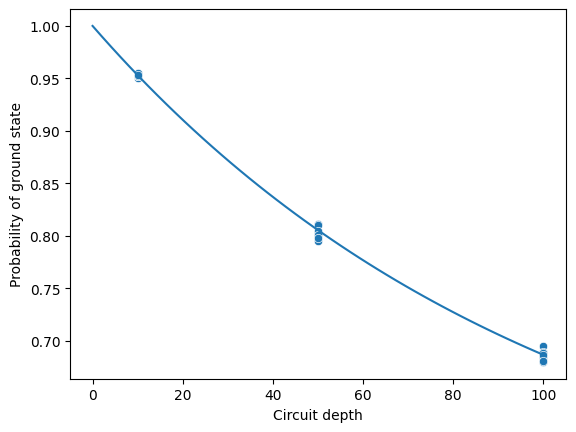

In [8]:
results.analyze()

Checking this result we have


In [ ]:
pauli_error_rate = results.gate_error
print(pauli_error_rate)

Which agrees very closely with our channel which we set up with $p=0.01$


In [15]:
ss_results = experiment.run_on_device(target="ss_unconstrained_simulator", repetitions=1000)

In [ ]:
ss_results.analyze()

As expected, since the Superstaq simulator is exact, we obtain a gate fidelity of 1.0
